<a href="https://colab.research.google.com/github/as183789043/Titanic-Survival-Prediction/blob/main/Titanic_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 安裝套件

In [1]:
!pip install -U scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 14.7 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.3.2
    Uninstalling scikit-learn-1.3.2:
      Successfully uninstalled scikit-learn-1.3.2


## 引入套件

In [43]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold,cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

## 讀取數據

In [6]:
train_csv=pd.read_csv("./train.csv")
test_csv=pd.read_csv("./test.csv")
train_csv.info(),test_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass  

(None, None)

## 模型欄位清理

In [7]:
y_train = train_csv['Survived']
X_train = train_csv.drop(['PassengerId','Survived','Name','Ticket','Cabin'],axis=1)
X_train

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,22.0,1,0,7.2500,S
1,1,female,38.0,1,0,71.2833,C
2,3,female,26.0,0,0,7.9250,S
3,1,female,35.0,1,0,53.1000,S
4,3,male,35.0,0,0,8.0500,S
...,...,...,...,...,...,...,...
886,2,male,27.0,0,0,13.0000,S
887,1,female,19.0,0,0,30.0000,S
888,3,female,NaN,1,2,23.4500,S
889,1,male,26.0,0,0,30.0000,C


## Pipeline建立

In [18]:
numerical = ['Age','Fare']
categorical = ['Sex','Embarked','Pclass']

In [23]:
numeric_preprocessor = Pipeline(
    steps=[
        ("imputation_mean", SimpleImputer(missing_values=np.nan, strategy="median")),
        ("scaler", StandardScaler()),
    ]
)

categorical_preprocessor = Pipeline(
    steps=[
        (
        "imputation_constant", SimpleImputer(missing_values=np.nan, strategy="most_frequent"),
        ),
        ("onehot", OneHotEncoder(handle_unknown="ignore",sparse_output=False)),
    ]
)

preprocessor = ColumnTransformer(
    [
        ("categorical", categorical_preprocessor, categorical),
        ("numerical", numeric_preprocessor, numerical),
    ]
)

pipe = make_pipeline(preprocessor, RandomForestClassifier(random_state= 42))
pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('imputation_constant',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Sex', 'Embarked',
                                                   'Pclass']),
                                                 ('numerical',
                                                  Pipeline(steps=[('imputation_mean',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Fare'])])),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=42))])

In [26]:
pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('categorical',
                                    Pipeline(steps=[('imputation_constant',
                                                     SimpleImputer(strategy='most_frequent')),
                                                    ('onehot',
                                                     OneHotEncoder(handle_unknown='ignore',
                                                                   sparse_output=False))]),
                                    ['Sex', 'Embarked', 'Pclass']),
                                   ('numerical',
                                    Pipeline(steps=[('imputation_mean',
                                                     SimpleImputer(strategy='median')),
                                                    ('scaler', StandardScaler())]),
                                    ['Age', 'Fare'])])),
  ('randomforestclassifier', RandomForestClassifier(random_stat

In [34]:
# 網格搜尋參數定義
param_grid = {
    'randomforestclassifier__bootstrap': [True, False],
    'randomforestclassifier__max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
    'randomforestclassifier__max_features': ['auto', 'sqrt'],
    'randomforestclassifier__min_samples_leaf': [1, 2, 4],
    'randomforestclassifier__min_samples_split': [2, 5, 10],
    'randomforestclassifier__n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]

    }

In [35]:
#最佳化查詢
grid = RandomizedSearchCV(pipe, param_distributions= param_grid , cv=5)
grid.fit(X_train, y_train)

print(f"Best parameters: {grid.best_params_}")
print(f"Best cross-validation score: {grid.best_score_:.2f}")

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
30 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 473, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "/usr/local/lib/pyth

Best parameters: {'randomforestclassifier__n_estimators': 1400, 'randomforestclassifier__min_samples_split': 5, 'randomforestclassifier__min_samples_leaf': 1, 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__max_depth': 10, 'randomforestclassifier__bootstrap': True}
Best cross-validation score: 0.83


## 最佳化參數

In [37]:
grid.best_params_

{'randomforestclassifier__n_estimators': 1400,
 'randomforestclassifier__min_samples_split': 5,
 'randomforestclassifier__min_samples_leaf': 1,
 'randomforestclassifier__max_features': 'sqrt',
 'randomforestclassifier__max_depth': 10,
 'randomforestclassifier__bootstrap': True}

In [41]:
best_model = grid.best_estimator_
best_model


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('imputation_constant',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Sex', 'Embarked',
                                                   'Pclass']),
                                                 ('numerical',
                                                  Pipeline(steps=[('imputation_mean',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Fare'])])),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=10, min_samples_split=5,
                                        n_estimators=1400, random_state=42))])

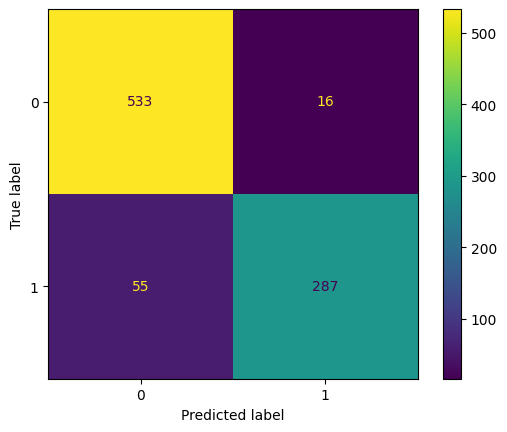

In [44]:
# Generate predictions with the best model
y_pred = best_model.predict(X_train)

# Create the confusion matrix
cm = confusion_matrix(y_train, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

## 保存Pipeline 到檔案

In [45]:
import joblib

# 保存 pipeline 成為檔案
joblib.dump(pipe, 'pipeline_model.pkl')


['pipeline_model.pkl']

## 取回檔案進行後續test.csv預測

In [47]:
# 載入保存的 pipeline
model = joblib.load('pipeline_model.pkl')

In [50]:
## 清理test.csv資料
X_test = test_csv.drop(['PassengerId','Name','Ticket','Cabin'],axis=1)
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Sex       418 non-null    object 
 2   Age       332 non-null    float64
 3   SibSp     418 non-null    int64  
 4   Parch     418 non-null    int64  
 5   Fare      417 non-null    float64
 6   Embarked  418 non-null    object 
dtypes: float64(2), int64(3), object(2)
memory usage: 23.0+ KB


## 模型預測

In [52]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred

array([0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [54]:
submission = pd.DataFrame({
    'PassengerId': test_csv['PassengerId'],
    'Survived': y_pred
})

# 儲存為 CSV 檔案
submission.to_csv('submission.csv', index=False)